In [12]:
# Junta as densidades em 1 arquivo só
import pandas as pd
import os
import numpy as np

electron_density_files = os.listdir('statistics')

# Lista de carboidratos no PDB
carbo_dict = pd.read_csv("/home/douglas/carboanalysis/carboanalysis/pdb/dicts/CCD_carbohydrate_list.tsv", sep="\t", header=None, names=['carbo_id', 'release_status'])
carbohydrate_residues = carbo_dict["carbo_id"].values

for file in electron_density_files:
    # Read
    electron_density_df = pd.read_csv('statistics/' + file)
    
    # Separa resíduos carboidrato e não-carboidrato
    not_carbo_df = electron_density_df.loc[~electron_density_df['ResName'].isin(carbohydrate_residues)].copy()
    electron_density_df = electron_density_df.loc[electron_density_df['ResName'].isin(carbohydrate_residues)].copy()
    
    # Converte colunas para numérico
    not_carbo_df['actual_significant_regional_density'] = pd.to_numeric(not_carbo_df['actual_significant_regional_density'], errors='coerce')
    not_carbo_df['num_electrons_actual_significant_regional_density'] = pd.to_numeric(not_carbo_df['num_electrons_actual_significant_regional_density'], errors='coerce')
    electron_density_df['actual_significant_regional_density'] = pd.to_numeric(electron_density_df['actual_significant_regional_density'], errors='coerce')
    electron_density_df['num_electrons_actual_significant_regional_density'] = pd.to_numeric(electron_density_df['num_electrons_actual_significant_regional_density'], errors='coerce')

    # Calcula mediana e MAD da densidade da proteína
    protein_median = not_carbo_df['actual_significant_regional_density'].median()
    mad = np.median(np.abs(not_carbo_df['actual_significant_regional_density'] - protein_median))

    #Adiciona entrada do pdb
    electron_density_df['entry'] = file[:4]

    # Calcula score robusto (sem fator 0.6745)
    if mad == 0 or np.isnan(mad):
        # Evita divisão por zero ou problemas se MAD não for calculável
        electron_density_df['robust_score'] = np.nan
    else:
        electron_density_df['robust_score'] = (
            electron_density_df['actual_significant_regional_density'] - protein_median
        ) / mad

    # Adiciona as medianas
    electron_density_df['actual_protein'] = protein_median
    electron_density_df['num_protein'] = not_carbo_df['num_electrons_actual_significant_regional_density'].median()
    

    # Escreve no arquivo final
    electron_density_df.to_csv('carbohydrate_densities_with_diff.csv', mode='a', header=False, index=False)

#Adiciona nomes das colunas e calcula diferenças
carbo_diffs = pd.read_csv('carbohydrate_densities_with_diff.csv', names = ['Index','asym','seq','sugar_code','Occupancy','actual_significant_regional_density','num_electrons_actual_significant_regional_density', 'entry', 'robust_score', 'actual_protein_median' , 'num_protein_median'])
carbo_diffs['actual_significant_diff'] = carbo_diffs['actual_significant_regional_density'] - carbo_diffs['actual_protein_median']
carbo_diffs['num_electrons_diff'] = carbo_diffs['num_electrons_actual_significant_regional_density'] - carbo_diffs['num_protein_median']
carbo_diffs.to_csv('carbohydrate_densities_with_diff.csv', mode='w', index=False)

In [13]:
#Usa o dataframe de piranoses pra plotar: densidade x puckering

electron_density_df = pd.read_csv('carbohydrate_densities_with_diff.csv')
pyranoses_df = pd.read_csv('pyranoses_df_to_compare.csv')

merged_df = pd.merge(
    electron_density_df,
    pyranoses_df[['entry', 'sugar_code', 'asym', 'seq', 'puck.phi_graus', 'puck.theta_graus']],
    on=['entry', 'sugar_code', 'asym', 'seq'],
    how='left'
)

In [16]:
#merged_df.to_csv('merged_df.csv')
merged_df.to_csv('merged_df.csv')

In [1]:
#Read merged_df - Puckering x Densidade

import pandas as pd

merged_df = pd.read_csv('merged_df.csv')

/tmp/ipykernel_91743/1721251119.py:39: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y, ax=ax_density, vertical=True, fill=True, color='gray')


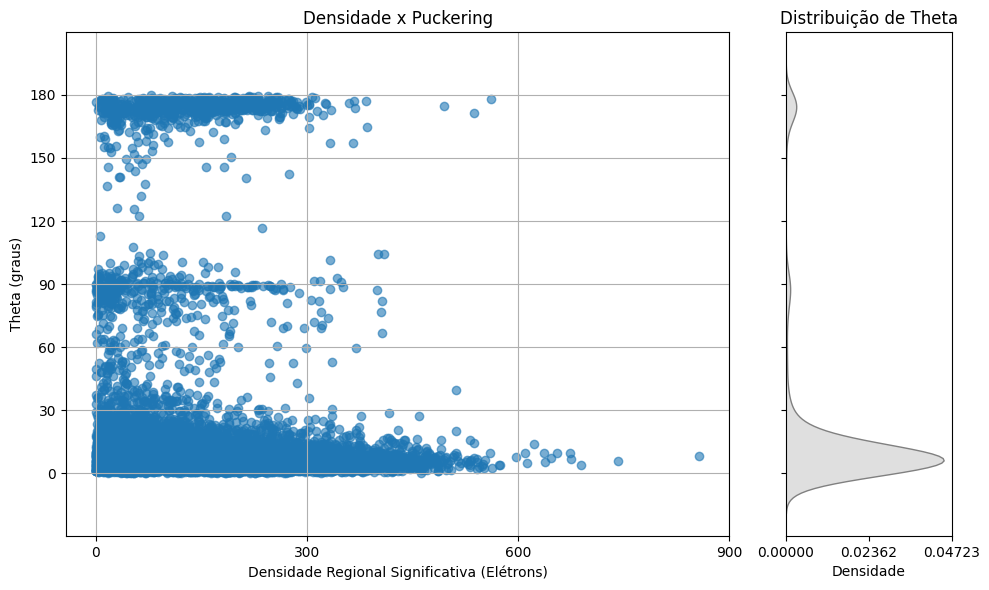

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filtra dados válidos
df_filtered = merged_df.dropna(subset=[
    'num_electrons_actual_significant_regional_density',
    'puck.theta_graus'
])

x = df_filtered['num_electrons_actual_significant_regional_density']
y = df_filtered['puck.theta_graus']

# Cria figura com scatter + gráfico de densidade vertical
fig, (ax_scatter, ax_density) = plt.subplots(
    1, 2,
    figsize=(10, 6),
    gridspec_kw={'width_ratios': [4, 1]},
    sharey=True
)

# Plot scatter (à esquerda)
ax_scatter.scatter(x, y, alpha=0.6)
ax_scatter.set_xlabel('Densidade Regional Significativa (Elétrons)')
ax_scatter.set_ylabel('Theta (graus)')
ax_scatter.set_title('Densidade x Puckering')
ax_scatter.grid(True)

# Ticks X e Y do scatter
x_min = x.min()
x_max = x.max()
x_ticks = np.arange(int(x_min // 300) * 300, int(x_max // 300 + 2) * 300, 300)
y_ticks = np.arange(0, 190, 30)

ax_scatter.set_xticks(x_ticks)
ax_scatter.set_yticks(y_ticks)

# Plot de densidade vertical (à direita)
sns.kdeplot(y, ax=ax_density, vertical=True, fill=True, color='gray')

# Ticks e rótulos do gráfico de densidade
ax_density.set_yticks(y_ticks)
ax_density.set_xticks(np.linspace(0, ax_density.get_xlim()[1], 3))  # 3 divisões no eixo X da densidade
ax_density.set_xlabel('Densidade')
ax_density.set_title('Distribuição de Theta')


# Layout
plt.tight_layout()
plt.show()


/tmp/ipykernel_91743/1130909576.py:51: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y, ax=ax_density_y, fill=True, color='gray', vertical=True)


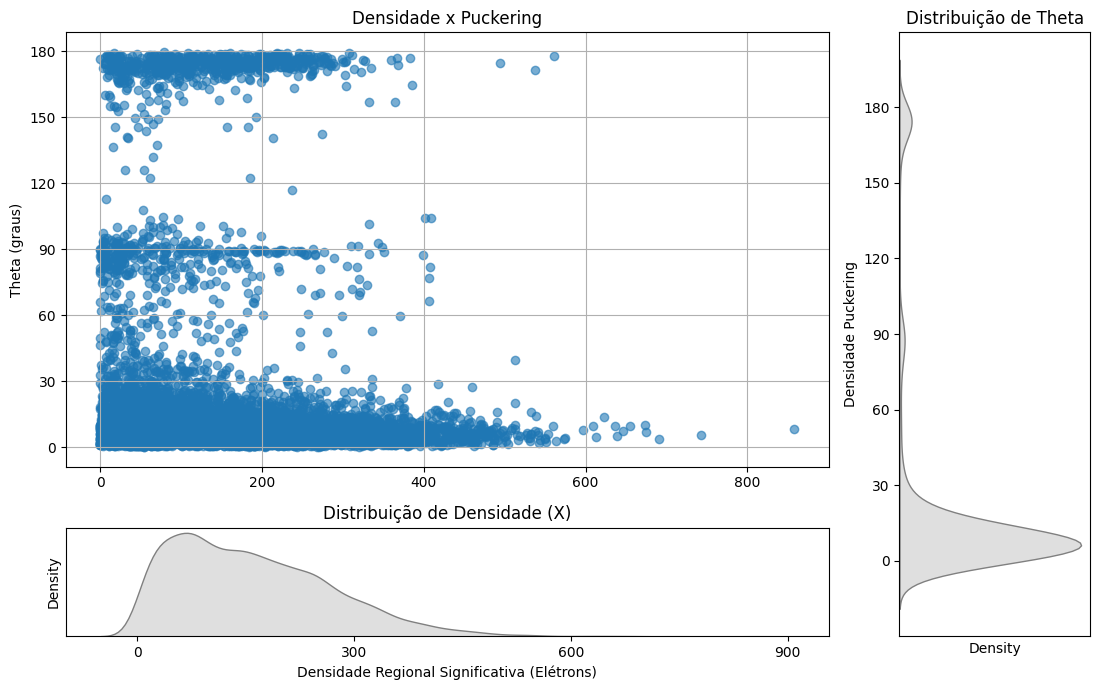

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filtra dados válidos
df_filtered = merged_df.dropna(subset=[
    'num_electrons_actual_significant_regional_density',
    'puck.theta_graus'
])

x = df_filtered['num_electrons_actual_significant_regional_density']
y = df_filtered['puck.theta_graus']

# Cria figura com scatter acima, gráfico de densidade horizontal abaixo e gráfico de densidade vertical à direita
fig = plt.figure(figsize=(12, 7))

# Cria o gridspec para a disposição dos gráficos
gs = fig.add_gridspec(2, 3, width_ratios=[4, 1, 0.1], height_ratios=[4, 1])

# Eixo para o gráfico de dispersão (scatter)
ax_scatter = fig.add_subplot(gs[0, 0])

# Eixo para o gráfico de densidade horizontal (abaixo do scatter)
ax_density_x = fig.add_subplot(gs[1, 0])

# Eixo para o gráfico de densidade vertical (à direita do scatter)
ax_density_y = fig.add_subplot(gs[:, 1])

# Plot scatter (no gráfico de dispersão)
ax_scatter.scatter(x, y, alpha=0.6)
ax_scatter.set_ylabel('Theta (graus)')
ax_scatter.set_title('Densidade x Puckering')
ax_scatter.grid(True)

# Ticks X e Y do scatter
x_min = x.min()
x_max = x.max()
x_ticks = np.arange(int(x_min // 300) * 300, int(x_max // 300 + 2) * 300, 300)
y_ticks = np.arange(0, 190, 30)

ax_scatter.set_yticks(y_ticks)

# Plot de densidade horizontal (abaixo do scatter)
sns.kdeplot(x, ax=ax_density_x, fill=True, color='gray')
ax_density_x.set_yticks([])  # Remove y-ticks do gráfico de densidade
ax_density_x.set_xlabel('Densidade Regional Significativa (Elétrons)')
ax_density_x.set_title('Distribuição de Densidade (X)')
ax_density_x.set_xticks(x_ticks)

# Plot de densidade vertical (à direita do scatter)
sns.kdeplot(y, ax=ax_density_y, fill=True, color='gray', vertical=True)
ax_density_y.set_xticks([])  # Remove x-ticks do gráfico de densidade
ax_density_y.set_yticks(y_ticks)
ax_density_y.set_ylabel('Densidade Puckering')
ax_density_y.set_title('Distribuição de Theta')

# Ajusta layout
plt.tight_layout()
plt.show()


/tmp/ipykernel_91743/1634632727.py:72: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y, ax=ax_density_y, fill=True, color='gray', vertical=True)


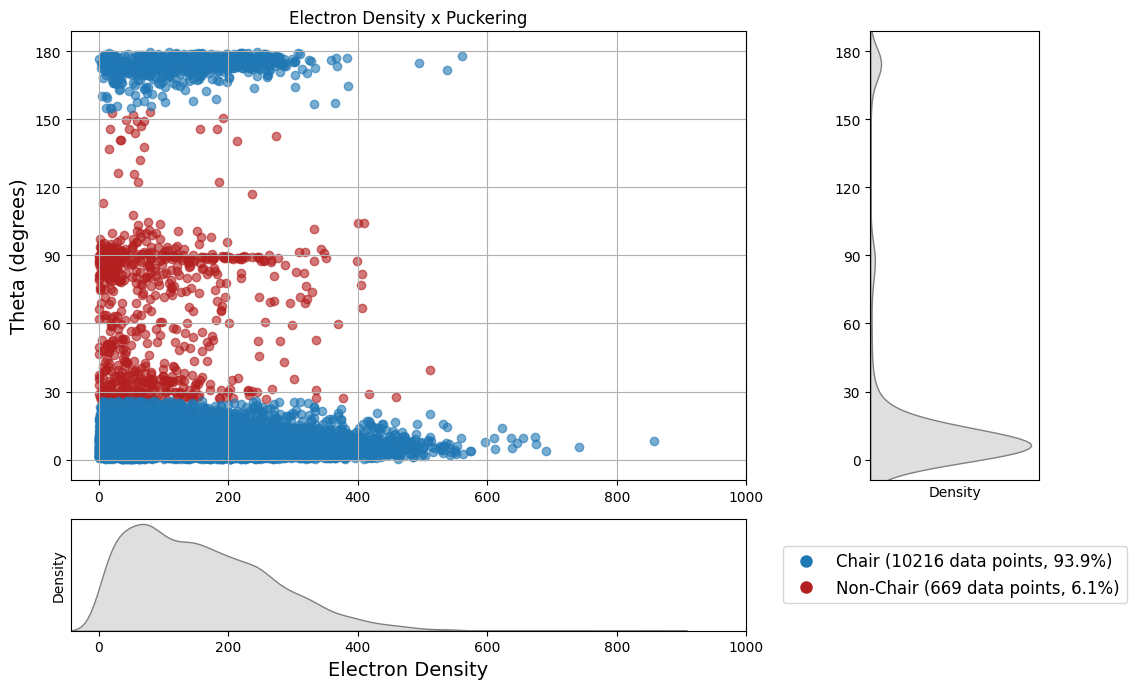

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

# Filtra dados válidos
df_filtered = merged_df.dropna(subset=[
    'num_electrons_actual_significant_regional_density',
    'puck.theta_graus'
])

x = df_filtered['num_electrons_actual_significant_regional_density']
y = df_filtered['puck.theta_graus']

# Cria figura com scatter acima, gráfico de densidade horizontal abaixo e gráfico de densidade vertical à direita
fig = plt.figure(figsize=(12, 7))

# Cria o gridspec para a disposição dos gráficos
gs = fig.add_gridspec(2, 3, width_ratios=[4, 1, 0.1], height_ratios=[4, 1])

# Eixo para o gráfico de dispersão (scatter)
ax_scatter = fig.add_subplot(gs[0, 0])

# Eixo para o gráfico de densidade horizontal (abaixo do scatter)
ax_density_x = fig.add_subplot(gs[1, 0])

# Eixo para o gráfico de densidade vertical (à direita do scatter)
ax_density_y = fig.add_subplot(gs[0, 1])

# Eixo para a legenda no campo livre (1, 1)
ax_legend = fig.add_subplot(gs[1, 1])
ax_legend.axis('off')  # Remove o eixo, já que ele só vai conter a legenda

# Filtra os pontos que têm theta entre 26 e 154 para colorir de vermelho
mask_red = (y >= 26) & (y <= 154)
mask_other = ~mask_red

# Contagem e porcentagem
total_points = len(x)
red_count = mask_red.sum()
other_count = mask_other.sum()

red_percentage = (red_count / total_points) * 100
other_percentage = (other_count / total_points) * 100

# Plot scatter (no gráfico de dispersão)
ax_scatter.scatter(x[mask_red], y[mask_red], alpha=0.6, color='#b41f1f', label='Theta entre 26 e 154')
ax_scatter.scatter(x[mask_other], y[mask_other], alpha=0.6, color='#1f77b4', label='Outros pontos')
ax_scatter.set_ylabel('Theta (degrees)', fontsize=14)
ax_scatter.set_title('Electron Density x Puckering')
ax_scatter.grid(True)

# Ticks X e Y do scatter
x_min = x.min()
x_max = x.max()
x_ticks = np.arange(int(x_min // 200) * 200, int(x_max // 200 + 2) * 200, 200)
y_ticks = np.arange(0, 190, 30)

ax_scatter.set_yticks(y_ticks)
ax_scatter.set_xticks(x_ticks)

# Plot de densidade horizontal (abaixo do scatter)
sns.kdeplot(x, ax=ax_density_x, fill=True, color='gray')
ax_density_x.set_yticks([])  # Remove y-ticks do gráfico de densidade
ax_density_x.set_xticks(x_ticks)
ax_density_x.set_xlabel('Electron Density', fontsize=14)
ax_density_x.set_title('')
ax_density_x.set_xlim(ax_scatter.get_xlim())


# Plot de densidade vertical (à direita do scatter)
sns.kdeplot(y, ax=ax_density_y, fill=True, color='gray', vertical=True)
ax_density_y.set_xticks([])  # Remove x-ticks do gráfico de densidade
ax_density_y.set_yticks(y_ticks)
ax_density_y.set_ylabel('')
ax_density_y.set_title('')
ax_density_y.set_ylim(ax_scatter.get_ylim())

# Adiciona a legenda no espaço livre com as cores correspondentes
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', markersize=10, label=f'Chair ({other_count} data points, {other_percentage:.1f}%)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#b41f1f', markersize=10, label=f'Non-Chair ({red_count} data points, {red_percentage:.1f}%)'),
]
ax_legend.legend(handles=legend_elements, loc='center', fontsize=12)

# Ajusta layout
plt.tight_layout()
plt.show()


/tmp/ipykernel_91743/2291699313.py:74: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y, ax=ax_density_y, fill=True, color='gray', vertical=True)


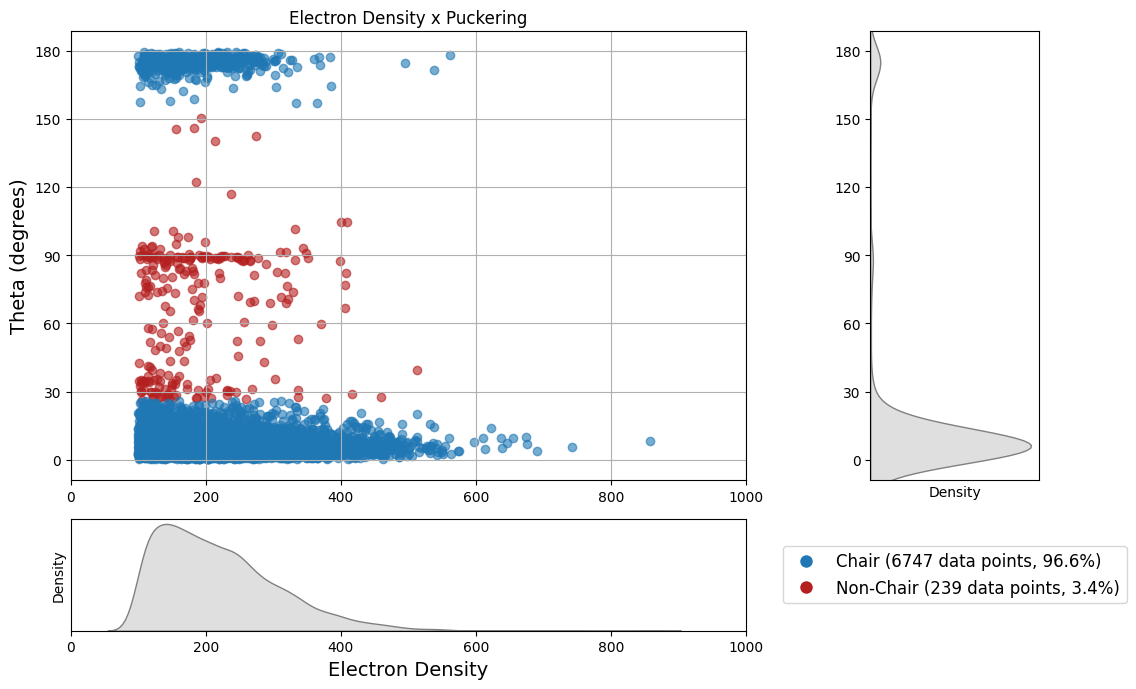

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

# Filtra dados válidos
df_filtered = merged_df.dropna(subset=[
    'num_electrons_actual_significant_regional_density',
    'puck.theta_graus'
])

df_filtered = df_filtered[df_filtered['num_electrons_actual_significant_regional_density'] > 100]

x = df_filtered['num_electrons_actual_significant_regional_density']
y = df_filtered['puck.theta_graus']

# Cria figura com scatter acima, gráfico de densidade horizontal abaixo e gráfico de densidade vertical à direita
fig = plt.figure(figsize=(12, 7))

# Cria o gridspec para a disposição dos gráficos
gs = fig.add_gridspec(2, 3, width_ratios=[4, 1, 0.1], height_ratios=[4, 1])

# Eixo para o gráfico de dispersão (scatter)
ax_scatter = fig.add_subplot(gs[0, 0])

# Eixo para o gráfico de densidade horizontal (abaixo do scatter)
ax_density_x = fig.add_subplot(gs[1, 0])

# Eixo para o gráfico de densidade vertical (à direita do scatter)
ax_density_y = fig.add_subplot(gs[0, 1])

# Eixo para a legenda no campo livre (1, 1)
ax_legend = fig.add_subplot(gs[1, 1])
ax_legend.axis('off')  # Remove o eixo, já que ele só vai conter a legenda

# Filtra os pontos que têm theta entre 26 e 154 para colorir de vermelho
mask_red = (y >= 26) & (y <= 154)
mask_other = ~mask_red

# Contagem e porcentagem
total_points = len(x)
red_count = mask_red.sum()
other_count = mask_other.sum()

red_percentage = (red_count / total_points) * 100
other_percentage = (other_count / total_points) * 100

# Plot scatter (no gráfico de dispersão)
ax_scatter.scatter(x[mask_red], y[mask_red], alpha=0.6, color='#b41f1f', label='Theta entre 26 e 154')
ax_scatter.scatter(x[mask_other], y[mask_other], alpha=0.6, color='#1f77b4', label='Outros pontos')
ax_scatter.set_ylabel('Theta (degrees)', fontsize=14)
ax_scatter.set_title('Electron Density x Puckering')
ax_scatter.grid(True)

# Ticks X e Y do scatter
x_min = x.min()
x_max = x.max()
x_ticks = np.arange(int(x_min // 200) * 200, int(x_max // 200 + 2) * 200, 200)
y_ticks = np.arange(0, 190, 30)

ax_scatter.set_yticks(y_ticks)
ax_scatter.set_xticks(x_ticks)

# Plot de densidade horizontal (abaixo do scatter)
sns.kdeplot(x, ax=ax_density_x, fill=True, color='gray')
ax_density_x.set_yticks([])  # Remove y-ticks do gráfico de densidade
ax_density_x.set_xticks(x_ticks)
ax_density_x.set_xlabel('Electron Density', fontsize=14)
ax_density_x.set_title('')
ax_density_x.set_xlim(ax_scatter.get_xlim())


# Plot de densidade vertical (à direita do scatter)
sns.kdeplot(y, ax=ax_density_y, fill=True, color='gray', vertical=True)
ax_density_y.set_xticks([])  # Remove x-ticks do gráfico de densidade
ax_density_y.set_yticks(y_ticks)
ax_density_y.set_ylabel('')
ax_density_y.set_title('')
ax_density_y.set_ylim(ax_scatter.get_ylim())

# Adiciona a legenda no espaço livre com as cores correspondentes
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', markersize=10, label=f'Chair ({other_count} data points, {other_percentage:.1f}%)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#b41f1f', markersize=10, label=f'Non-Chair ({red_count} data points, {red_percentage:.1f}%)'),
]
ax_legend.legend(handles=legend_elements, loc='center', fontsize=12)

# Ajusta layout
plt.tight_layout()
plt.show()


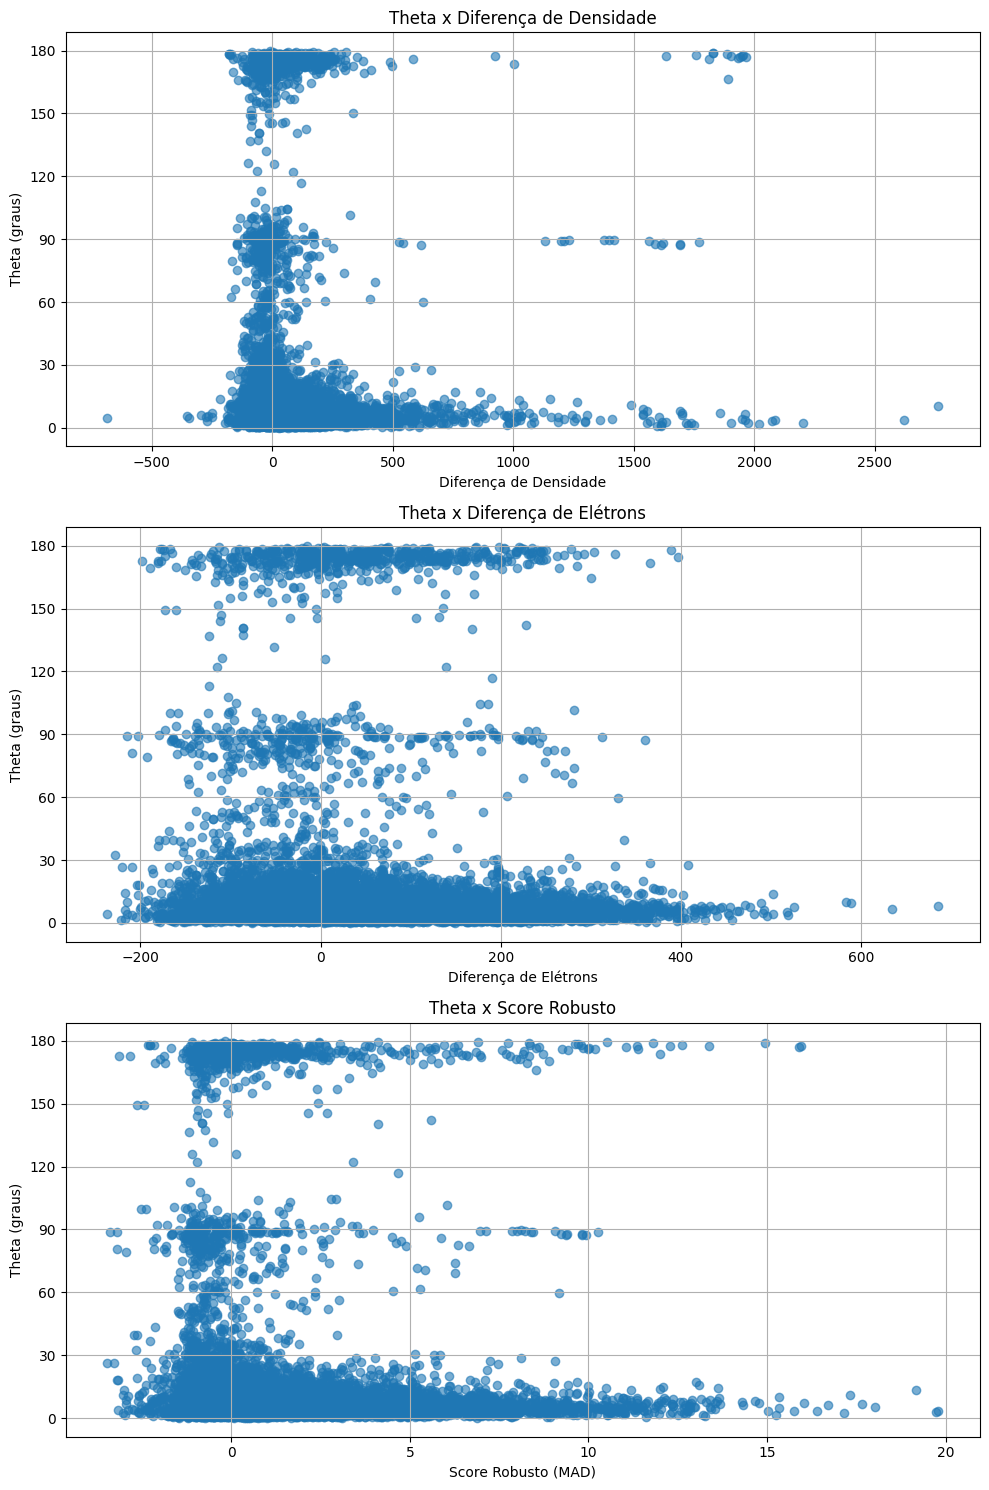

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Lê o DataFrame
df = pd.read_csv('merged_df.csv')

# Converte colunas relevantes para numérico
cols_to_convert = [
    'actual_significant_diff',
    'num_electrons_diff',
    'robust_score',
    'puck.theta_graus'
]
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Remove valores ausentes
df = df.dropna(subset=['puck.theta_graus'])

# Define os ticks de theta (eixo Y)
y_ticks = np.arange(0, 190, 30)

# Cria figura com 3 subplots empilhados
fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharey=True)

# Plot 1 - Diferença de densidade
axs[0].scatter(df['actual_significant_diff'], df['puck.theta_graus'], alpha=0.6)
axs[0].set_xlabel('Diferença de Densidade')
axs[0].set_ylabel('Theta (graus)')
axs[0].set_title('Theta x Diferença de Densidade')
axs[0].set_yticks(y_ticks)
axs[0].grid(True)

# Plot 2 - Diferença de elétrons
axs[1].scatter(df['num_electrons_diff'], df['puck.theta_graus'], alpha=0.6)
axs[1].set_xlabel('Diferença de Elétrons')
axs[1].set_ylabel('Theta (graus)')
axs[1].set_title('Theta x Diferença de Elétrons')
axs[1].set_yticks(y_ticks)
axs[1].grid(True)

# Plot 3 - Score robusto
axs[2].scatter(df['robust_score'], df['puck.theta_graus'], alpha=0.6)
axs[2].set_xlabel('Score Robusto (MAD)')
axs[2].set_title('Theta x Score Robusto')
axs[2].set_ylabel('Theta (graus)')
axs[2].set_yticks(y_ticks)
axs[2].grid(True)

plt.tight_layout()
plt.show()


/tmp/ipykernel_91743/2095732438.py:36: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['puck.theta_graus'], ax=axs[0, 1], vertical=True, fill=True, color='gray')
/tmp/ipykernel_91743/2095732438.py:51: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['puck.theta_graus'], ax=axs[1, 1], vertical=True, fill=True, color='gray')
/tmp/ipykernel_91743/2095732438.py:66: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['puck.theta_graus'], ax=axs[2, 1], vertical=True, fill=True, color='gray')


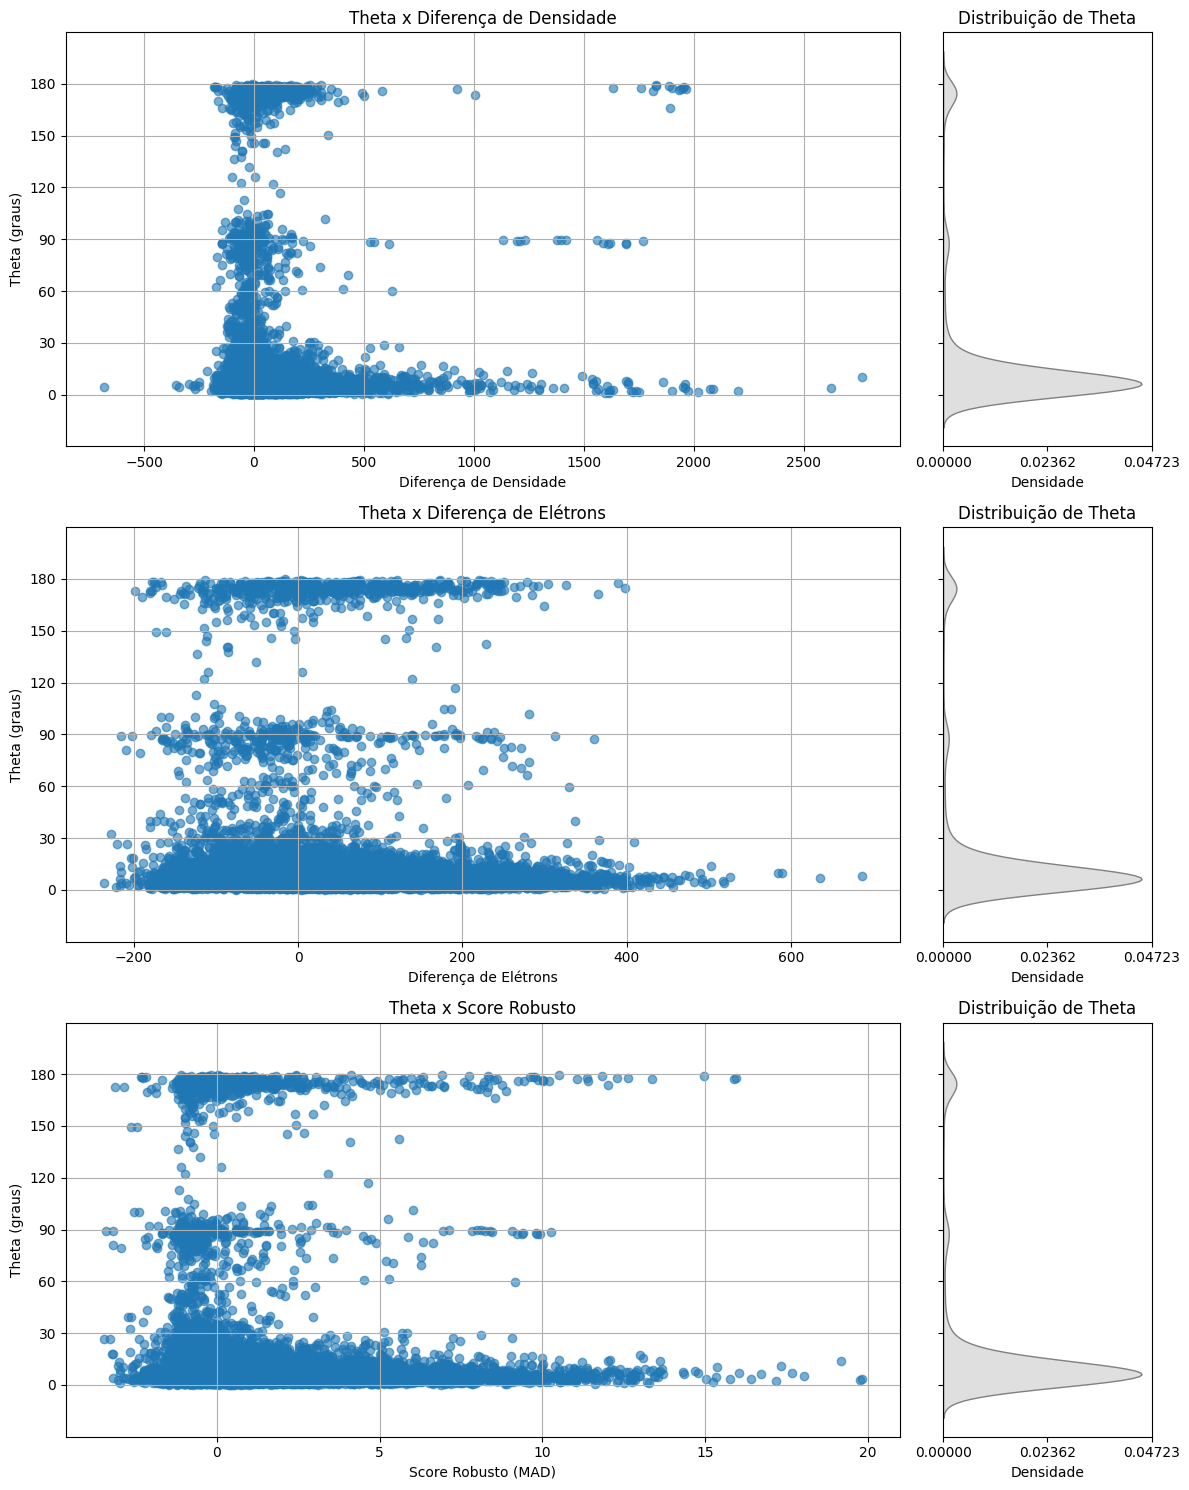

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Lê o DataFrame
df = pd.read_csv('merged_df.csv')

# Converte colunas relevantes para numérico
cols_to_convert = [
    'actual_significant_diff',
    'num_electrons_diff',
    'robust_score',
    'puck.theta_graus'
]
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Remove valores ausentes
df = df.dropna(subset=['puck.theta_graus'])

# Define os ticks de theta (eixo Y)
y_ticks = np.arange(0, 190, 30)

# Cria figura com 3 subplots empilhados e uma coluna extra para os gráficos de densidade
fig, axs = plt.subplots(3, 2, figsize=(12, 15), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

# Gráfico 1 - Diferença de Densidade
axs[0, 0].scatter(df['actual_significant_diff'], df['puck.theta_graus'], alpha=0.6)
axs[0, 0].set_xlabel('Diferença de Densidade')
axs[0, 0].set_ylabel('Theta (graus)')
axs[0, 0].set_title('Theta x Diferença de Densidade')
axs[0, 0].set_yticks(y_ticks)
axs[0, 0].grid(True)

# Distribuição de Theta (1º gráfico)
sns.kdeplot(df['puck.theta_graus'], ax=axs[0, 1], vertical=True, fill=True, color='gray')
axs[0, 1].set_yticks(y_ticks)
axs[0, 1].set_xticks(np.linspace(0, axs[0, 1].get_xlim()[1], 3))
axs[0, 1].set_xlabel('Densidade')
axs[0, 1].set_title('Distribuição de Theta')

# Gráfico 2 - Diferença de Elétrons
axs[1, 0].scatter(df['num_electrons_diff'], df['puck.theta_graus'], alpha=0.6)
axs[1, 0].set_xlabel('Diferença de Elétrons')
axs[1, 0].set_ylabel('Theta (graus)')
axs[1, 0].set_title('Theta x Diferença de Elétrons')
axs[1, 0].set_yticks(y_ticks)
axs[1, 0].grid(True)

# Distribuição de Theta (2º gráfico)
sns.kdeplot(df['puck.theta_graus'], ax=axs[1, 1], vertical=True, fill=True, color='gray')
axs[1, 1].set_yticks(y_ticks)
axs[1, 1].set_xticks(np.linspace(0, axs[1, 1].get_xlim()[1], 3))
axs[1, 1].set_xlabel('Densidade')
axs[1, 1].set_title('Distribuição de Theta')

# Gráfico 3 - Score Robusto
axs[2, 0].scatter(df['robust_score'], df['puck.theta_graus'], alpha=0.6)
axs[2, 0].set_xlabel('Score Robusto (MAD)')
axs[2, 0].set_ylabel('Theta (graus)')
axs[2, 0].set_title('Theta x Score Robusto')
axs[2, 0].set_yticks(y_ticks)
axs[2, 0].grid(True)

# Distribuição de Theta (3º gráfico)
sns.kdeplot(df['puck.theta_graus'], ax=axs[2, 1], vertical=True, fill=True, color='gray')
axs[2, 1].set_yticks(y_ticks)
axs[2, 1].set_xticks(np.linspace(0, axs[2, 1].get_xlim()[1], 3))
axs[2, 1].set_xlabel('Densidade')
axs[2, 1].set_title('Distribuição de Theta')

plt.tight_layout()
plt.show()
